In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy
from tqdm import tqdm
from balu3.fs.sel    import sfs, clean
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
from scipy.stats import binom, betabinom
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed
from tensorflow.keras.layers import Masking, LSTM, Dense

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
import keras

In [2]:
#Para la LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Data historica

dfHistorico1 = pd.read_csv("dataHistórica/resultados_pasados_premier.csv")
dfHistorico1 = dfHistorico1.drop("Unnamed: 0",axis = 1)
dfHistorico1 = dfHistorico1.drop(["Position_last_year_home", "Position_last_year_away",
                                  "Points_last_year_home", "Points_last_year_away"],axis = 1) # Para hacer el merge con el segundo.

dfHistorico2 = pd.read_csv("dataHistórica/restoDeLigas.csv")
dfHistorico2 = dfHistorico2.drop("Unnamed: 0",axis = 1)

dfHistorico2['Date'] = pd.to_datetime(dfHistorico2['Date'], dayfirst=True, errors='coerce')
dfHistorico2['Date'] = dfHistorico2['Date'].dt.strftime('%Y-%m-%d')
dfHistorico2 = dfHistorico2[dfHistorico2["Date"] >"2010-01-01"] # Seleccion solo de partidos de 2010 en adelante (porque el otro dataframe tiene info desde ahí)


In [ ]:
dfHistorico = pd.concat([dfHistorico1, dfHistorico2], axis=0)
dfHistorico = dfHistorico.reset_index(drop=True)

In [ ]:
# Data tipo evento

dfEvent = pd.read_csv("dataWhoScored/WhoScoredTeamPerMatchSpatial4x3TimeDiv5.csv")
dfEvent = dfEvent.drop("Unnamed: 0",axis = 1)

In [ ]:
# Ajuste manual de equipos:
# Los que no tengan match son un string vacio.

histToEventNameV1 = {
   "Arsenal": "Arsenal", "Aston Villa": "Aston Villa", "Barnsley": "", "Birmingham City": "Birmingham", "Blackburn": "Blackburn","Blackpool": "Blackpool",
   "Bolton" : "Bolton", "Bournemouth": "Bournemouth", "Bradford City": "", "Brentford": "Brentford", "Brighton": "Brighton", "Burnley": "Burnley", "Cardiff City": "Cardiff",
   "Charlton Ath": "", "Chelsea": "Chelsea", "Coventry City": "", "Crystal Palace": "Crystal Palace", "Derby County":"", "Everton": "Everton", "Fulham": "Fulham",
   "Huddersfield": "Huddersfield", "Hull City": "Hull", "Ipswich Town": "", "Leeds United": "Leeds", "Leicester City": "Leicester", "Liverpool": "Liverpool",
   "Manchester City": "Man City", "Manchester Utd": "Man Utd", "Middlesbrough": "Middlesbrough", "Newcastle Utd": "Newcastle", "Norwich City": "Norwich",
   "Nott'ham Forest": "Nottingham Forest", "Oldham Athletic": "", "Portsmouth": "", "QPR": "QPR", "Reading": "Reading", "Sheffield Utd": "Sheff Utd", "Sheffield Weds": "",
   "Southampton": "Southampton", "Stoke City": "Stoke", "Sunderland": "Sunderland", "Swansea City": "Swansea", "Swindon Town":  "", "Tottenham": "Tottenham", "Watford":"Watford",
   "West Brom": "WBA", "West Ham": "West Ham", "Wigan Athletic": "Wigan", "Wimbledon": "", "Wolves": "Wolves"
}
len(histToEventNameV1)

In [ ]:
histToEventName = {
   "Arsenal": "Arsenal", "Aston Villa": "Aston Villa", "Barnsley": "", "Birmingham City": "Birmingham", "Blackburn": "Blackburn","Blackpool": "Blackpool",
   "Bolton" : "Bolton", "Bournemouth": "Bournemouth", "Bradford City": "", "Brentford": "Brentford", "Brighton": "Brighton", "Burnley": "Burnley", "Cardiff City": "Cardiff",
   "Charlton Ath": "", "Chelsea": "Chelsea", "Coventry City": "", "Crystal Palace": "Crystal Palace", "Derby County":"", "Everton": "Everton", "Fulham": "Fulham",
   "Huddersfield": "Huddersfield", "Hull City": "Hull", "Ipswich Town": "", "Leeds United": "Leeds", "Leicester City": "Leicester", "Liverpool": "Liverpool",
   "Manchester City": "Man City", "Manchester Utd": "Man Utd", "Middlesbrough": "Middlesbrough", "Newcastle Utd": "Newcastle", "Norwich City": "Norwich",
   "Nott'ham Forest": "Nottingham Forest", "Oldham Athletic": "", "Portsmouth": "", "QPR": "QPR", "Reading": "Reading", "Sheffield Utd": "Sheff Utd", "Sheffield Weds": "",
   "Southampton": "Southampton", "Stoke City": "Stoke", "Sunderland": "Sunderland", "Swansea City": "Swansea", "Swindon Town":  "", "Tottenham": "Tottenham", "Watford":"Watford",
   "West Brom": "WBA", "West Ham": "West Ham", "Wigan Athletic": "Wigan", "Wimbledon": "", "Wolves": "Wolves", #V1
   "Aachen":"","Ajaccio":"AC Ajaccio", "Alaves":"Deportivo Alaves", "Almeria": "Almeria", "Amiens":"Amiens","Angers":"Angers", "Arles":"Arles-Avignon", "Ascoli":"",
   "Atalanta":"Atalanta", "Ath Bilbao":"Athletic Club", "Ath Madrid":"Atletico", "Augsburg":"Augsburg", "Auxerre":"Auxerre", "Barcelona":"Barcelona", "Bari":"Bari",
   "Bastia":"SC Bastia", "Bayern Munich":"Bayern", "Benevento":"Benevento", "Betis":"Real Betis", "Bielefeld":"Arminia Bielefeld", "Bochum": "Bochum", "Bologna":"Bologna",
   "Bordeaux":"Bordeaux", "Boulogne": "", "Braunschweig": "Eintracht Braunschweig", "Brescia":"Brescia", "Brest":"Brest", "Cadiz":"Cadiz", "Caen": "Caen", "Cagliari":"Cagliari",
   "Carpi":"AC Carpi", "Catania":"Catania", "Celta":"Celta Vigo", "Cesena": "Cesena", "Chievo":"Chievo", "Clermont":"Clermont Foot", "Cordoba": "Cordoba", "Cottbus":"",
   "Cremonese":"Cremonese", "Crotone":"Crotone", "Darmstadt":"Darmstadt", "Dijon": "Dijon", "Dortmund":"Borussia Dortmund", "Duisburg":"", "Eibar":"Eibar", "Ein Frankfurt":"Eintracht Frankfurt",
   "Elche": "Elche", "Empoli": "Empoli", "Espanol": "Espanyol", "Evian Thonon Gaillard": "Evian", "FC Koln": "FC Koln", "Fiorentina": "Fiorentina", "Fortuna Dusseldorf": "Fortuna Duesseldorf",
   "Freiburg":"Freiburg", "Frosinone": "Frosinone", "Genoa": "Genoa", "Getafe": "Getafe", "Gimnastic":"", "Girona": "Girona", "Granada": "Granada", "Grenoble":"",
   "Greuther Furth": "Greuther Fuerth", "Guingamp": "Guingamp", "Hamburg":"Hamburg", "Hannover":"Hannover", "Hansa Rostock":"", "Heidenheim":"FC Heidenheim", "Hercules":"Hercules",
   "Hertha":"Hertha Berlin", "Hoffenheim":"Hoffenheim", "Huesca": "SD Huesca", "Ingolstadt": "Ingolstadt", "Inter": "Inter", "Juventus":"Juventus", "Kaiserslautern":"Kaiserslautern",
   "Karlsruhe":"", "La Coruna": "Deportivo", "Las Palmas": "Las Palmas", "Lazio": "Lazio", "Le Havre": "Le Havre", "Le Mans":"", "Lecce": "Lecce", "Leganes":"Leganes", "Lens": "Lens",
   "Levante": "Levante", "Leverkusen": "Leverkusen", "Lille":"Lille", "Livorno": "Livorno", "Lorient":"Lorient", "Lyon": "Lyon", "M'gladbach": "Borussia M.Gladbach", "Mainz": "Mainz",
   "Malaga":"Malaga", "Mallorca":"Mallorca", "Messina": "", "Metz": "Metz", "Milan": "AC Milan", "Monaco": "Monaco", "Montpellier": "Montpellier", "Monza": "Monza", "Murcia":"",
   "Nancy":"Nancy", "Nantes":"Nantes", "Napoli":"Napoli", "Nice":"Nice", "Nimes":"Nimes", "Novara": "Novara", "Numancia":"", "Nurnberg":"Nuernberg", "Osasuna": "Osasuna",
   "Paderborn": "Paderborn", "Palermo": "Palermo", "Paris SG": "PSG", "Parma": "Parma Calcio 1913", "Pescara":"Pescara", "RB Leipzig": "RBL","Real Madrid":"Real Madrid", 
   "Recreativo":"", "Reggina":"", "Reims": "Reims", "Rennes":"Rennes", "Roma":"Roma", "Salernitana": "Salernitana", "Sampdoria":"Sampdoria", "Santander": "Racing Santander",
   "Sassuolo":"Sassuolo", "Schalke 04": "Schalke", "Sedan":"", "Sevilla":"Sevilla", "Siena": "Siena", "Sochaux": "Sochaux", "Sociedad": "Real Sociedad", "Sp Gijon":"Sporting Gijon",
   "Spal":"SPAL 2013", "Spezia": "Spezia", "St Etienne":"Saint-Etienne", "St Pauli":"St. Pauli", "Strasbourg":"Strasbourg", "Stuttgart": "Stuttgart", "Tenerife":"", "Torino":"Torino",
   "Toulouse":"Toulouse", "Treviso":"", "Troyes":"Troyes", "Udinese": "Udinese", "Union Berlin":"Union Berlin", "Valencia": "Valencia", "Valenciennes": "Valenciennes", "Valladolid": "Real Valladolid",
   "Vallecano": "Rayo Vallecano", "Venezia":"Venezia", "Verona":"Verona", "Villarreal": "Villarreal", "Werder Bremen": "Werder Bremen", "Wolfsburg": "Wolfsburg", "Xerez": "", "Zaragoza": "Real Zaragoza"
}
len(histToEventName)

In [ ]:
# Para buscar nombres

a = dfHistorico["Team_home"].unique().tolist()
a.sort()
print(a)

In [ ]:
# Para buscar nombres

a = dfEvent["Team"].unique().tolist()
a.sort()
print(a)

In [ ]:
# Nombres de data histórica a nombres de tipo evento.

dfHistorico["Team_home"] = dfHistorico["Team_home"].map(histToEventName)
dfHistorico["Team_away"] = dfHistorico["Team_away"].map(histToEventName)

In [ ]:
# Comprobamos que no esten datos vacios

dfHistorico.isnull().sum() 

In [ ]:
# Primero revisamos si estan todos los partidos compatibles, para que sea más robusta la solución

indexHistorical = []
for i in tqdm(range(len(dfHistorico))):
    stringHome = dfHistorico.iloc[i].Team_home
    stringAway = dfHistorico.iloc[i].Team_away
    date = dfHistorico.iloc[i].Date

    dfAux = dfEvent[dfEvent.Date == date]

    dfHome = dfAux[dfAux.Team == stringHome].add_prefix("Home")
    dfAway = dfAux[dfAux.Team == stringAway].add_prefix("Away")

    # dfHome.reset_index(drop=True, inplace=True)
    # dfAway.reset_index(drop=True, inplace=True)
    if len(dfHome) + len(dfAway) == 2: 
        indexHistorical.append(i)
    # concat = pd.concat([dfHome, dfAway], axis = 1)
    # test.append(concat)
    # Buscamos los partidos que tenemos información
    

In [ ]:
# Creamos el dataframe de partidos a buscar

dfHistoricoCompatible = dfHistorico.iloc[indexHistorical].reset_index(drop=True)
dfHistoricoCompatible = dfHistoricoCompatible.dropna(axis=0)

In [ ]:
dfHistoricoCompatible

In [ ]:
dfHistoricoCompatible.isnull().sum()

In [ ]:
# goals_succ = dfEvent.filter(regex='Goal_Successful_bin').columns.tolist()
# goals_unsucc = dfEvent.filter(regex='Goal_Unsuccessful_bin').columns.tolist()
# goals_succ.extend(goals_unsucc)
# goals = goals_succ

# intervals = ["0-45","45-90"]
# intervals = ["0-15","15-30","30-45","45-60","60-75","75-90"]
intervals = ["0-5","5-10","10-15","15-20","20-25","25-30", "30-35","35-40","40-45",
             "45-50","50-55","55-60","60-65","65-70","70-75", "75-80","80-85","85-90"]

Xdata = []
ydata = []
for i in tqdm(range(len(dfHistoricoCompatible))):
    stringHome = dfHistoricoCompatible.iloc[i].Team_home
    stringAway = dfHistoricoCompatible.iloc[i].Team_away
    date = dfHistoricoCompatible.iloc[i].Date

    # dfAux = dfEvent[dfEvent.Date == date].drop(goals, axis=1) #Test sin los goles
    dfAux = dfEvent[dfEvent.Date == date]

    dfHome = dfAux[dfAux.Team == stringHome].add_prefix("Home")
    dfAway = dfAux[dfAux.Team == stringAway].add_prefix("Away")

    # Dropear valores redundantes
    dfHome = dfHome.drop(["HomeTeam","HomeDate","HomeGoals","Homegame_id"], axis = 1)
    dfAway = dfAway.drop(["AwayTeam","AwayDate","AwayGoals","Awaygame_id"], axis = 1)

    dfHome.reset_index(drop=True, inplace=True)
    dfAway.reset_index(drop=True, inplace=True)

    concat = pd.concat([dfHome, dfAway], axis = 1).reset_index(drop=True)
    x = []
    if len(concat) == 0:
        pass
    else:
        for inter in intervals:
            intervals_columns = concat.filter(regex=f'{inter}$').columns.tolist()
            hist = dfHistoricoCompatible.iloc[i:i+1].drop(["Date", "Team_home", "Team_away", "result", "Goals_home", "Goals_away", "Wk"], axis=1).values
            x.append(np.append(concat[intervals_columns].values[0], hist))
        ydata.append(dfHistoricoCompatible.iloc[i:i+1]["result"].values[0])
        x = np.array(x)
        Xdata.append(x)

In [3]:
# Para guardar el dataset y no correrlo varias veces 
# np.save("Space4x3Time5.npy", np.array(Xdata))
# np.save("LabelsSpace4x3Time5.npy", np.array(ydata))

Xdata = np.load("InGameDataOrdenada\Space4x3Time5.npy")
ydata = np.load("InGameDataOrdenada\LabelsSpace4x3Time5.npy")

# MLP solo datos históricos

In [ ]:
X = dfHistoricoCompatible.drop(["Date", "Team_home", "Team_away", "result", "Goals_home", "Goals_away", "Wk"], axis=1).values
y = dfHistoricoCompatible.result

# y = to_categorical(y, num_classes=3)

# Dividir los datos en conjuntos de entrenamiento y prueba
split = int(0.8 * X.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = MinMaxScaler()
# scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_norm.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
# Compilar el modelo
with tf.device('GPU:0'): # Usar gpu
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=10^(-6))

history = model.fit(X_train_norm, y_train, verbose=1, epochs=100, batch_size=8,
                    validation_data=(X_test_norm, y_test), callbacks=[early_stopping, reduce_lr])

In [ ]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50,
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=30, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)

# LSTM

In [5]:
# Full data
X = np.array(Xdata)
y = np.array(ydata)
y = to_categorical(y, num_classes=3)


In [5]:
X.shape

(22209, 18, 1270)

In [6]:
y.shape

(22209, 3)

In [10]:
n_samples, sequence_length, n_features = X.shape

# División de los datos en 65% entrenamiento, 15% validación y 20% prueba
train_size = int(0.65 * n_samples)
val_size = int(0.15 * n_samples)
test_size = n_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [11]:
# Sin clean
# scaler = MinMaxScaler()
# X_train_reshaped = X_train.reshape(-1, X.shape[2])
# X_train_normalized = scaler.fit_transform(X_train_reshaped)
# X_train_normalized = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

# X_test_reshaped = X_test.reshape(-1, X.shape[2])
# X_test_normalized = scaler.transform(X_test_reshaped)
# X_test_normalized = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


# Con clean 
X_train_reshaped = X_train.reshape(-1, X.shape[2])
X_test_reshaped = X_test.reshape(-1, X.shape[2])
X_val_reshaped = X_val.reshape(-1, X.shape[2])

sclean  = clean(X_train_reshaped)      # indices of selected features
X_train_reshaped = deepcopy(X_train_reshaped[:,sclean])
X_test_reshaped = deepcopy(X_test_reshaped[:,sclean])
X_val_reshaped = deepcopy(X_val_reshaped[:,sclean])

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)
X_val_normalized = scaler.transform(X_val_reshaped)

X_train_normalized = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], len(sclean))
X_test_normalized = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], len(sclean))
X_val_normalized = X_val_normalized.reshape(X_val.shape[0], X_val.shape[1], len(sclean))


In [9]:
X_train_normalized.shape

(14435, 18, 763)

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


In [11]:
# Definir el modelo LSTM
model = Sequential()
l2_recurrent_parameter = 0.01
l_2_kernel_regularizer= 0.01
# Primera capa LSTM con Dropout y regularización L2
model.add(LSTM(256, return_sequences=True, input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2]),
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=False,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compilación del modelo
with tf.device('GPU:0'): # Usar gpu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="models\InGame",
    monitor='val_loss',
    mode='min',
    save_best_only=True)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0000000001)

history = model.fit(X_train_normalized, y_train, verbose=1, epochs=1000, batch_size=16,
                    validation_data=(X_val_normalized, y_val), callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])

Epoch 1/1000
903/903 [==============================] - ETA: 0s - loss: 3.9265 - accuracy: 0.6292

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 33s 32ms/step - loss: 3.9265 - accuracy: 0.6292 - val_loss: 2.8755 - val_accuracy: 0.3428 - lr: 0.0010
Epoch 2/1000
903/903 [==============================] - ETA: 0s - loss: 1.1016 - accuracy: 0.7162

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 28s 31ms/step - loss: 1.1016 - accuracy: 0.7162 - val_loss: 1.0203 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 3/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.6371 - accuracy: 0.8210 - val_loss: 1.3464 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 4/1000
900/903 [============================>.] - ETA: 0s - loss: 0.5123 - accuracy: 0.8648

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.5118 - accuracy: 0.8651 - val_loss: 0.3805 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 5/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.4572 - accuracy: 0.8865 - val_loss: 0.8604 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 6/1000
900/903 [============================>.] - ETA: 0s - loss: 0.4430 - accuracy: 0.8956

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.4427 - accuracy: 0.8957 - val_loss: 0.3484 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 7/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.4883 - accuracy: 0.8971 - val_loss: 0.6701 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 8/1000
903/903 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.9113

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.4297 - accuracy: 0.9113 - val_loss: 0.2753 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 9/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.3447 - accuracy: 0.9277 - val_loss: 1.2394 - val_accuracy: 0.4977 - lr: 0.0010
Epoch 10/1000
901/903 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.9391

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.3215 - accuracy: 0.9391 - val_loss: 0.1905 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 11/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.2978 - accuracy: 0.9473 - val_loss: 0.2125 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 12/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.3127 - accuracy: 0.9437 - val_loss: 0.5740 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 13/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.2883 - accuracy: 0.9489 - val_loss: 1.1415 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 14/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.2693 - accuracy: 0.9527 - val_loss: 0.5108 - val_accuracy: 0.8466 - lr: 0.0010
Epoch 15/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.2646 - accuracy: 0.9548 - val_loss: 0.2132 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 16/1000
903/903 [==============================]

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1755 - accuracy: 0.9804 - val_loss: 0.1773 - val_accuracy: 0.9820 - lr: 2.0000e-04
Epoch 22/1000
901/903 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9864

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1470 - accuracy: 0.9864 - val_loss: 0.1464 - val_accuracy: 0.9880 - lr: 2.0000e-04
Epoch 23/1000
901/903 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9842

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1457 - accuracy: 0.9842 - val_loss: 0.1346 - val_accuracy: 0.9928 - lr: 2.0000e-04
Epoch 24/1000
900/903 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9834

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.1433 - accuracy: 0.9833 - val_loss: 0.1220 - val_accuracy: 0.9919 - lr: 2.0000e-04
Epoch 25/1000
900/903 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9858

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1354 - accuracy: 0.9857 - val_loss: 0.1146 - val_accuracy: 0.9922 - lr: 2.0000e-04
Epoch 26/1000
903/903 [==============================] - 15s 16ms/step - loss: 0.1314 - accuracy: 0.9857 - val_loss: 0.1540 - val_accuracy: 0.9808 - lr: 2.0000e-04
Epoch 27/1000
902/903 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9860

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.1294 - accuracy: 0.9860 - val_loss: 0.1117 - val_accuracy: 0.9931 - lr: 2.0000e-04
Epoch 28/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.1215 - accuracy: 0.9870 - val_loss: 0.1191 - val_accuracy: 0.9889 - lr: 2.0000e-04
Epoch 29/1000
903/903 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9877

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1189 - accuracy: 0.9877 - val_loss: 0.1072 - val_accuracy: 0.9940 - lr: 2.0000e-04
Epoch 30/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.1170 - accuracy: 0.9870 - val_loss: 0.1077 - val_accuracy: 0.9919 - lr: 2.0000e-04
Epoch 31/1000
903/903 [==============================] - 16s 18ms/step - loss: 0.1166 - accuracy: 0.9877 - val_loss: 0.1154 - val_accuracy: 0.9898 - lr: 2.0000e-04
Epoch 32/1000
901/903 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9879

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.1122 - accuracy: 0.9879 - val_loss: 0.1051 - val_accuracy: 0.9928 - lr: 2.0000e-04
Epoch 33/1000
903/903 [==============================] - 16s 18ms/step - loss: 0.1148 - accuracy: 0.9868 - val_loss: 0.1163 - val_accuracy: 0.9865 - lr: 2.0000e-04
Epoch 34/1000
901/903 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9875

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 27s 30ms/step - loss: 0.1113 - accuracy: 0.9874 - val_loss: 0.0956 - val_accuracy: 0.9943 - lr: 2.0000e-04
Epoch 35/1000
903/903 [==============================] - 19s 21ms/step - loss: 0.1040 - accuracy: 0.9897 - val_loss: 0.0965 - val_accuracy: 0.9937 - lr: 2.0000e-04
Epoch 36/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.1094 - accuracy: 0.9865 - val_loss: 0.1166 - val_accuracy: 0.9874 - lr: 2.0000e-04
Epoch 37/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.1006 - accuracy: 0.9886 - val_loss: 0.1741 - val_accuracy: 0.9700 - lr: 2.0000e-04
Epoch 38/1000
903/903 [==============================] - 17s 18ms/step - loss: 0.1038 - accuracy: 0.9890 - val_loss: 0.0966 - val_accuracy: 0.9934 - lr: 2.0000e-04
Epoch 39/1000
903/903 [==============================] - 18s 20ms/step - loss: 0.0985 - accuracy: 0.9892 - val_loss: 0.1709 - val_accuracy: 0.9643 - lr: 2.0000e-04
Epoch 40/1000
902/903 [=======

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 27s 29ms/step - loss: 0.1013 - accuracy: 0.9882 - val_loss: 0.0931 - val_accuracy: 0.9940 - lr: 2.0000e-04
Epoch 41/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0993 - accuracy: 0.9877 - val_loss: 0.1413 - val_accuracy: 0.9763 - lr: 2.0000e-04
Epoch 42/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0969 - accuracy: 0.9893 - val_loss: 0.1084 - val_accuracy: 0.9922 - lr: 2.0000e-04
Epoch 43/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.1008 - accuracy: 0.9879 - val_loss: 0.0959 - val_accuracy: 0.9913 - lr: 2.0000e-04
Epoch 44/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.1008 - accuracy: 0.9870 - val_loss: 0.0948 - val_accuracy: 0.9946 - lr: 2.0000e-04
Epoch 45/1000
903/903 [==============================] - 17s 19ms/step - loss: 0.0932 - accuracy: 0.9888 - val_loss: 0.0958 - val_accuracy: 0.9928 - lr: 2.0000e-04
Epoch 46/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.0758 - accuracy: 0.9937 - val_loss: 0.0881 - val_accuracy: 0.9934 - lr: 4.0000e-05
Epoch 52/1000
902/903 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9941

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.0722 - accuracy: 0.9941 - val_loss: 0.0860 - val_accuracy: 0.9937 - lr: 4.0000e-05
Epoch 53/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0723 - accuracy: 0.9930 - val_loss: 0.0882 - val_accuracy: 0.9931 - lr: 4.0000e-05
Epoch 54/1000
900/903 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9926

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.0750 - accuracy: 0.9924 - val_loss: 0.0843 - val_accuracy: 0.9937 - lr: 4.0000e-05
Epoch 55/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0691 - accuracy: 0.9936 - val_loss: 0.0867 - val_accuracy: 0.9934 - lr: 4.0000e-05
Epoch 56/1000
901/903 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9938

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.0703 - accuracy: 0.9937 - val_loss: 0.0828 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 57/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0694 - accuracy: 0.9944 - val_loss: 0.0936 - val_accuracy: 0.9904 - lr: 4.0000e-05
Epoch 58/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0663 - accuracy: 0.9944 - val_loss: 0.0841 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 59/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0667 - accuracy: 0.9940 - val_loss: 0.0846 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 60/1000
903/903 [==============================] - 16s 18ms/step - loss: 0.0640 - accuracy: 0.9945 - val_loss: 0.0875 - val_accuracy: 0.9931 - lr: 4.0000e-05
Epoch 61/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0660 - accuracy: 0.9938 - val_loss: 0.0871 - val_accuracy: 0.9931 - lr: 4.0000e-05
Epoch 62/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 25s 28ms/step - loss: 0.0686 - accuracy: 0.9930 - val_loss: 0.0805 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 64/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0637 - accuracy: 0.9943 - val_loss: 0.0833 - val_accuracy: 0.9937 - lr: 4.0000e-05
Epoch 65/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0628 - accuracy: 0.9943 - val_loss: 0.0874 - val_accuracy: 0.9928 - lr: 4.0000e-05
Epoch 66/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0603 - accuracy: 0.9957 - val_loss: 0.0845 - val_accuracy: 0.9934 - lr: 4.0000e-05
Epoch 67/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0633 - accuracy: 0.9948 - val_loss: 0.0820 - val_accuracy: 0.9934 - lr: 4.0000e-05
Epoch 68/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0611 - accuracy: 0.9951 - val_loss: 0.0823 - val_accuracy: 0.9943 - lr: 4.0000e-05
Epoch 69/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 29ms/step - loss: 0.0603 - accuracy: 0.9947 - val_loss: 0.0802 - val_accuracy: 0.9943 - lr: 4.0000e-05
Epoch 72/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0578 - accuracy: 0.9956 - val_loss: 0.0808 - val_accuracy: 0.9943 - lr: 4.0000e-05
Epoch 73/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0591 - accuracy: 0.9957 - val_loss: 0.0806 - val_accuracy: 0.9937 - lr: 4.0000e-05
Epoch 74/1000
903/903 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9952

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 26s 28ms/step - loss: 0.0594 - accuracy: 0.9952 - val_loss: 0.0796 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 75/1000
901/903 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9942

INFO:tensorflow:Assets written to: models\InGame\assets


INFO:tensorflow:Assets written to: models\InGame\assets


903/903 [==============================] - 27s 30ms/step - loss: 0.0621 - accuracy: 0.9943 - val_loss: 0.0794 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 76/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0567 - accuracy: 0.9950 - val_loss: 0.0868 - val_accuracy: 0.9925 - lr: 4.0000e-05
Epoch 77/1000
903/903 [==============================] - 18s 19ms/step - loss: 0.0633 - accuracy: 0.9946 - val_loss: 0.0822 - val_accuracy: 0.9934 - lr: 4.0000e-05
Epoch 78/1000
903/903 [==============================] - 16s 17ms/step - loss: 0.0583 - accuracy: 0.9954 - val_loss: 0.0837 - val_accuracy: 0.9940 - lr: 4.0000e-05
Epoch 79/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0605 - accuracy: 0.9940 - val_loss: 0.0917 - val_accuracy: 0.9895 - lr: 4.0000e-05
Epoch 80/1000
903/903 [==============================] - 15s 17ms/step - loss: 0.0580 - accuracy: 0.9955 - val_loss: 0.0807 - val_accuracy: 0.9931 - lr: 4.0000e-05
Epoch 81/1000
903/903 [=======

In [12]:
intervals = ["0-5","5-10","10-15","15-20","20-25","25-30", "30-35","35-40","40-45",
             "45-50","50-55","55-60","60-65","65-70","70-75", "75-80","80-85","85-90"]
loss, acc = [], []
for i in range(1, X_test_normalized.shape[1]+1):
    print(intervals[i-1])
    aux = model.evaluate(X_test_normalized[:, :i, :], y_test)
    loss.append(aux[0])
    acc.append(aux[1])

0-5
139/139 [==============================] - 2s 6ms/step - loss: 5.0673 - accuracy: 0.2471
5-10
139/139 [==============================] - 1s 6ms/step - loss: 5.3470 - accuracy: 0.3417
10-15
139/139 [==============================] - 1s 6ms/step - loss: 5.4999 - accuracy: 0.3840
15-20
139/139 [==============================] - 1s 6ms/step - loss: 5.2533 - accuracy: 0.4324
20-25
139/139 [==============================] - 1s 7ms/step - loss: 4.9379 - accuracy: 0.4695
25-30
139/139 [==============================] - 1s 7ms/step - loss: 4.6551 - accuracy: 0.5006
30-35
139/139 [==============================] - 1s 7ms/step - loss: 4.3604 - accuracy: 0.5330
35-40
139/139 [==============================] - 1s 6ms/step - loss: 4.0508 - accuracy: 0.5625
40-45
139/139 [==============================] - 1s 7ms/step - loss: 3.7480 - accuracy: 0.5951
45-50
139/139 [==============================] - 1s 7ms/step - loss: 3.4064 - accuracy: 0.6298
50-55
139/139 [==============================] - 1s 7

## Pruebas con padding

Media de las muestras: 12.574857039938763


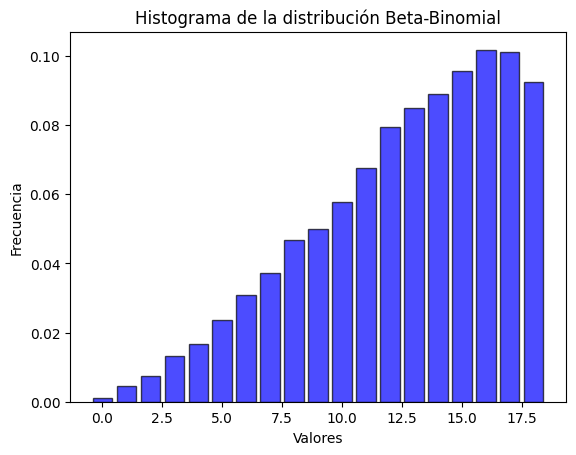

In [6]:
import numpy as np
from scipy.stats import betabinom

# Parámetros de la distribución beta-binomial
n = X.shape[1]   # Número de ensayos
a = 0.70*4  # Parámetro alpha de la distribución beta
b = 0.30*4   # Parámetro beta de la distribución beta

# Número de muestras aleatorias que deseas generar
num_samples = X.shape[0]

# Generar números aleatorios de una distribución beta-binomial
samples = betabinom.rvs(n, a, b, size=num_samples)

# Calcular y mostrar la media de las muestras generadas
mean_samples = np.mean(samples)
print(f"Media de las muestras: {mean_samples}")

values, counts = np.unique(samples, return_counts=True)

# Graficar un barplot de las muestras generadas
plt.bar(values, counts / num_samples, color='b', edgecolor='black', alpha=0.7)

# Títulos y etiquetas
plt.title('Histograma de la distribución Beta-Binomial')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar la gráfica
plt.show()

In [12]:
# Full data
XFullpad = np.array(Xdata)
y = np.array(ydata)
y = to_categorical(y, num_classes=3)


In [13]:
# Con clean 
X_train_reshaped = X_train.reshape(-1, X.shape[2])
X_test_reshaped = X_test.reshape(-1, X.shape[2])
X_val_reshaped = X_val.reshape(-1, X.shape[2])

sclean  = clean(X_train_reshaped)      # indices of selected features
X_train_reshaped = deepcopy(X_train_reshaped[:,sclean])
X_test_reshaped = deepcopy(X_test_reshaped[:,sclean])
X_val_reshaped = deepcopy(X_val_reshaped[:,sclean])

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)
X_val_normalized = scaler.transform(X_val_reshaped)

X_train_normalized = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], len(sclean))
X_test_normalized = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], len(sclean))
X_val_normalized = X_val_normalized.reshape(X_val.shape[0], X_val.shape[1], len(sclean))


In [14]:
# Parámetros de la distribución binomial 
# n = X.shape[1]
# p = 0.9
# size = X.shape[0]
# random_values = binom.rvs(n, p, size=size)

# Parámetros de la distribución beta-binomial
n = XFullpad.shape[1]   # Número de ensayos
size = XFullpad.shape[0]
a = 0.70*4  # Parámetro alpha de la distribución beta
b = 0.30*4   # Parámetro beta de la distribución beta

random_values = betabinom.rvs(n, a, b, size=size)

# random_values = np.random.randint(1, n+1, size)

In [15]:
# Binom  and uniform
Xpad_train = []
ypad_train = []
for i in range(train_size):
    Xpad_train.append(X_train_normalized[i][:random_values[i]+1])
    ypad_train.append(y[i])

Xpad_val = []
ypad_val = []
for i in range(val_size):
    Xpad_val.append(X_val_normalized[i][:random_values[i+train_size]+1])
    ypad_val.append(y[i+train_size])

# Full
# Xpad_train = []
# ypad_train = []
# for i in range(split):
#     for j in range(n):
#         Xpad_train.append(X_train_normalized[i][:j+1])
#         ypad_train.append(y[i])

# Xpad_val = []
# ypad_val = []
# for i in range(len(XFullpad)-train_size):
#     for j in range(n):
#         Xpad_val.append(X_val_normalized[i][:j+1])
#         ypad_val.append(y[i+train_size])

In [16]:
Xpad_train = pad_sequences(Xpad_train, padding='post', dtype='float64')
Xpad_val = pad_sequences(Xpad_val, padding='post', dtype='float64')
ypad_train = np.array(ypad_train)
ypad_val = np.array(ypad_val)

In [17]:
from tensorflow.keras.layers import LSTM, Dense, Embedding


l2_recurrent_parameter = 0.01
l_2_kernel_regularizer= 0.01

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(Xpad_train.shape[1], Xpad_train.shape[2])))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=True,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(LSTM(256, return_sequences=False,
               kernel_regularizer=l2(l_2_kernel_regularizer), recurrent_regularizer=l2(l2_recurrent_parameter)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compilación del modelo
with tf.device('GPU:0'): # Usar gpu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="models\InGamePadd",
    monitor='val_loss',
    mode= "min",
    save_best_only=True)
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=10^(-9))

history = model.fit(Xpad_train, ypad_train, verbose=1, epochs=1000, batch_size=16,
                    validation_data=(Xpad_val, ypad_val), callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])

Epoch 1/1000
902/903 [============================>.] - ETA: 0s - loss: 3.9618 - accuracy: 0.5184

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 51s 45ms/step - loss: 3.9612 - accuracy: 0.5185 - val_loss: 1.8184 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 2/1000
903/903 [==============================] - 21s 23ms/step - loss: 1.2277 - accuracy: 0.5735 - val_loss: 2.0390 - val_accuracy: 0.5005 - lr: 0.0010
Epoch 3/1000
903/903 [==============================] - ETA: 0s - loss: 1.0908 - accuracy: 0.6025

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 37s 41ms/step - loss: 1.0908 - accuracy: 0.6025 - val_loss: 1.1322 - val_accuracy: 0.6223 - lr: 0.0010
Epoch 4/1000
901/903 [============================>.] - ETA: 0s - loss: 0.8820 - accuracy: 0.6573

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 38s 42ms/step - loss: 0.8823 - accuracy: 0.6572 - val_loss: 0.8770 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 5/1000
903/903 [==============================] - 21s 23ms/step - loss: 0.8210 - accuracy: 0.6772 - val_loss: 0.9021 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 6/1000
903/903 [==============================] - 20s 22ms/step - loss: 0.8085 - accuracy: 0.6865 - val_loss: 1.1219 - val_accuracy: 0.6482 - lr: 0.0010
Epoch 7/1000
903/903 [==============================] - ETA: 0s - loss: 0.7799 - accuracy: 0.7015

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 36s 40ms/step - loss: 0.7799 - accuracy: 0.7015 - val_loss: 0.7650 - val_accuracy: 0.7172 - lr: 0.0010
Epoch 8/1000
903/903 [==============================] - 23s 26ms/step - loss: 0.7583 - accuracy: 0.7104 - val_loss: 0.7778 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 9/1000
903/903 [==============================] - 21s 24ms/step - loss: 0.7409 - accuracy: 0.7104 - val_loss: 0.9081 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 10/1000
903/903 [==============================] - 21s 23ms/step - loss: 0.7444 - accuracy: 0.7092 - val_loss: 1.2244 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 11/1000
903/903 [==============================] - 21s 23ms/step - loss: 0.7372 - accuracy: 0.7112 - val_loss: 1.0224 - val_accuracy: 0.4869 - lr: 0.0010
Epoch 12/1000
902/903 [============================>.] - ETA: 0s - loss: 0.7313 - accuracy: 0.7177

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 36s 40ms/step - loss: 0.7315 - accuracy: 0.7176 - val_loss: 0.7533 - val_accuracy: 0.6683 - lr: 0.0010
Epoch 13/1000
903/903 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7172

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 38s 42ms/step - loss: 0.7230 - accuracy: 0.7172 - val_loss: 0.7348 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 14/1000
903/903 [==============================] - 22s 24ms/step - loss: 0.7206 - accuracy: 0.7118 - val_loss: 0.8433 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 15/1000
903/903 [==============================] - 21s 23ms/step - loss: 0.7135 - accuracy: 0.7153 - val_loss: 0.8886 - val_accuracy: 0.5860 - lr: 0.0010
Epoch 16/1000
903/903 [==============================] - 22s 25ms/step - loss: 0.7183 - accuracy: 0.7171 - val_loss: 0.7717 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 17/1000
903/903 [==============================] - 22s 24ms/step - loss: 0.7055 - accuracy: 0.7185 - val_loss: 0.7356 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 18/1000
901/903 [============================>.] - ETA: 0s - loss: 0.7089 - accuracy: 0.7188

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 38s 42ms/step - loss: 0.7093 - accuracy: 0.7187 - val_loss: 0.6855 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 19/1000
903/903 [==============================] - 21s 24ms/step - loss: 0.7104 - accuracy: 0.7195 - val_loss: 0.7905 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 20/1000
903/903 [==============================] - 21s 24ms/step - loss: 0.7039 - accuracy: 0.7197 - val_loss: 0.8933 - val_accuracy: 0.5623 - lr: 0.0010
Epoch 21/1000
903/903 [==============================] - 24s 26ms/step - loss: 0.7055 - accuracy: 0.7182 - val_loss: 0.7649 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 22/1000
903/903 [==============================] - 25s 27ms/step - loss: 0.7053 - accuracy: 0.7193 - val_loss: 0.7406 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 23/1000
903/903 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.7201

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 42s 47ms/step - loss: 0.6953 - accuracy: 0.7201 - val_loss: 0.6815 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 24/1000
903/903 [==============================] - 25s 28ms/step - loss: 0.7007 - accuracy: 0.7210 - val_loss: 0.7877 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 25/1000
903/903 [==============================] - 24s 27ms/step - loss: 0.6991 - accuracy: 0.7223 - val_loss: 0.7718 - val_accuracy: 0.6626 - lr: 0.0010
Epoch 26/1000
903/903 [==============================] - 24s 26ms/step - loss: 0.6952 - accuracy: 0.7204 - val_loss: 0.8871 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 27/1000
903/903 [==============================] - 25s 28ms/step - loss: 0.7002 - accuracy: 0.7216 - val_loss: 1.2511 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 28/1000
903/903 [==============================] - 24s 26ms/step - loss: 0.6875 - accuracy: 0.7289 - val_loss: 0.7536 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 29/1000
903/903 [==============================]

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 45s 50ms/step - loss: 0.6441 - accuracy: 0.7453 - val_loss: 0.6769 - val_accuracy: 0.7382 - lr: 5.0000e-04
Epoch 42/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.6512 - accuracy: 0.7444 - val_loss: 1.1113 - val_accuracy: 0.5551 - lr: 5.0000e-04
Epoch 43/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6516 - accuracy: 0.7406 - val_loss: 0.6807 - val_accuracy: 0.7097 - lr: 5.0000e-04
Epoch 44/1000
903/903 [==============================] - 26s 29ms/step - loss: 0.6463 - accuracy: 0.7428 - val_loss: 0.7558 - val_accuracy: 0.7019 - lr: 5.0000e-04
Epoch 45/1000
903/903 [==============================] - 26s 29ms/step - loss: 0.6435 - accuracy: 0.7485 - val_loss: 0.9569 - val_accuracy: 0.6238 - lr: 5.0000e-04
Epoch 46/1000
902/903 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.7427

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 43s 48ms/step - loss: 0.6416 - accuracy: 0.7428 - val_loss: 0.6720 - val_accuracy: 0.7349 - lr: 5.0000e-04
Epoch 47/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6522 - accuracy: 0.7380 - val_loss: 1.1539 - val_accuracy: 0.3846 - lr: 5.0000e-04
Epoch 48/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6394 - accuracy: 0.7486 - val_loss: 0.6745 - val_accuracy: 0.7343 - lr: 5.0000e-04
Epoch 49/1000
902/903 [============================>.] - ETA: 0s - loss: 0.6362 - accuracy: 0.7459

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 49ms/step - loss: 0.6361 - accuracy: 0.7460 - val_loss: 0.6474 - val_accuracy: 0.7469 - lr: 5.0000e-04
Epoch 50/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.6387 - accuracy: 0.7460 - val_loss: 1.0018 - val_accuracy: 0.5617 - lr: 5.0000e-04
Epoch 51/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6427 - accuracy: 0.7413 - val_loss: 0.6591 - val_accuracy: 0.7274 - lr: 5.0000e-04
Epoch 52/1000
902/903 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.7417

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 48ms/step - loss: 0.6471 - accuracy: 0.7415 - val_loss: 0.6377 - val_accuracy: 0.7436 - lr: 5.0000e-04
Epoch 53/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6406 - accuracy: 0.7467 - val_loss: 0.6536 - val_accuracy: 0.7433 - lr: 5.0000e-04
Epoch 54/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.6377 - accuracy: 0.7458 - val_loss: 0.7117 - val_accuracy: 0.7202 - lr: 5.0000e-04
Epoch 55/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6413 - accuracy: 0.7468 - val_loss: 0.8763 - val_accuracy: 0.6169 - lr: 5.0000e-04
Epoch 56/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6304 - accuracy: 0.7492 - val_loss: 0.6487 - val_accuracy: 0.7370 - lr: 5.0000e-04
Epoch 57/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6386 - accuracy: 0.7483 - val_loss: 0.7128 - val_accuracy: 0.7184 - lr: 5.0000e-04
Epoch 58/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 49ms/step - loss: 0.6124 - accuracy: 0.7587 - val_loss: 0.6344 - val_accuracy: 0.7430 - lr: 2.5000e-04
Epoch 64/1000
903/903 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.7634

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 45s 50ms/step - loss: 0.6047 - accuracy: 0.7634 - val_loss: 0.6315 - val_accuracy: 0.7505 - lr: 2.5000e-04
Epoch 65/1000
902/903 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.7621

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 49ms/step - loss: 0.6060 - accuracy: 0.7622 - val_loss: 0.6208 - val_accuracy: 0.7487 - lr: 2.5000e-04
Epoch 66/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.5996 - accuracy: 0.7685 - val_loss: 0.6574 - val_accuracy: 0.7490 - lr: 2.5000e-04
Epoch 67/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6076 - accuracy: 0.7624 - val_loss: 0.6534 - val_accuracy: 0.7355 - lr: 2.5000e-04
Epoch 68/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6024 - accuracy: 0.7635 - val_loss: 0.6221 - val_accuracy: 0.7526 - lr: 2.5000e-04
Epoch 69/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6067 - accuracy: 0.7616 - val_loss: 0.6277 - val_accuracy: 0.7457 - lr: 2.5000e-04
Epoch 70/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.6036 - accuracy: 0.7656 - val_loss: 0.6476 - val_accuracy: 0.7376 - lr: 2.5000e-04
Epoch 71/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 49ms/step - loss: 0.5902 - accuracy: 0.7701 - val_loss: 0.6144 - val_accuracy: 0.7496 - lr: 1.2500e-04
Epoch 78/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.5849 - accuracy: 0.7706 - val_loss: 0.6292 - val_accuracy: 0.7526 - lr: 1.2500e-04
Epoch 79/1000
902/903 [============================>.] - ETA: 0s - loss: 0.5840 - accuracy: 0.7704

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 44s 48ms/step - loss: 0.5844 - accuracy: 0.7703 - val_loss: 0.6118 - val_accuracy: 0.7484 - lr: 1.2500e-04
Epoch 80/1000
903/903 [==============================] - 28s 30ms/step - loss: 0.5804 - accuracy: 0.7731 - val_loss: 0.6164 - val_accuracy: 0.7511 - lr: 1.2500e-04
Epoch 81/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.5821 - accuracy: 0.7710 - val_loss: 0.6223 - val_accuracy: 0.7469 - lr: 1.2500e-04
Epoch 82/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5758 - accuracy: 0.7749 - val_loss: 0.6208 - val_accuracy: 0.7472 - lr: 1.2500e-04
Epoch 83/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5814 - accuracy: 0.7713 - val_loss: 0.6335 - val_accuracy: 0.7478 - lr: 1.2500e-04
Epoch 84/1000
903/903 [==============================] - 27s 30ms/step - loss: 0.5849 - accuracy: 0.7686 - val_loss: 0.6158 - val_accuracy: 0.7508 - lr: 1.2500e-04
Epoch 85/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 46s 51ms/step - loss: 0.5682 - accuracy: 0.7763 - val_loss: 0.6073 - val_accuracy: 0.7505 - lr: 6.2500e-05
Epoch 91/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5678 - accuracy: 0.7809 - val_loss: 0.6194 - val_accuracy: 0.7475 - lr: 6.2500e-05
Epoch 92/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5720 - accuracy: 0.7769 - val_loss: 0.6118 - val_accuracy: 0.7481 - lr: 6.2500e-05
Epoch 93/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5689 - accuracy: 0.7784 - val_loss: 0.6113 - val_accuracy: 0.7475 - lr: 6.2500e-05
Epoch 94/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5701 - accuracy: 0.7735 - val_loss: 0.6095 - val_accuracy: 0.7472 - lr: 6.2500e-05
Epoch 95/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5695 - accuracy: 0.7764 - val_loss: 0.6089 - val_accuracy: 0.7493 - lr: 6.2500e-05
Epoch 96/1000
903/903 [=======

INFO:tensorflow:Assets written to: models\InGamePadd\assets


INFO:tensorflow:Assets written to: models\InGamePadd\assets


903/903 [==============================] - 45s 50ms/step - loss: 0.5633 - accuracy: 0.7799 - val_loss: 0.6067 - val_accuracy: 0.7520 - lr: 3.1250e-05
Epoch 111/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5637 - accuracy: 0.7789 - val_loss: 0.6111 - val_accuracy: 0.7511 - lr: 3.1250e-05
Epoch 112/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5645 - accuracy: 0.7805 - val_loss: 0.6086 - val_accuracy: 0.7499 - lr: 3.1250e-05
Epoch 113/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5639 - accuracy: 0.7778 - val_loss: 0.6084 - val_accuracy: 0.7496 - lr: 3.1250e-05
Epoch 114/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5590 - accuracy: 0.7807 - val_loss: 0.6084 - val_accuracy: 0.7478 - lr: 3.1250e-05
Epoch 115/1000
903/903 [==============================] - 28s 31ms/step - loss: 0.5588 - accuracy: 0.7809 - val_loss: 0.6091 - val_accuracy: 0.7502 - lr: 3.1250e-05
Epoch 116/1000
903/903 [=

In [18]:
loss, acc = [], []
for i in range(1, X_test_normalized.shape[1]+1):
    print(intervals[i-1])
    aux = model.evaluate(X_test_normalized[:, :i, :], y_test)
    loss.append(aux[0])
    acc.append(aux[1])
print(np.mean(acc))

NameError: name 'intervals' is not defined